In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import random
import collections
import copy
import pickle
import itertools
from statistics import mean

***
### TRANSFORMER ENCODER-DECODER IMPLEMENTATION FROM SCRATCH ON THE MACHINE TRANSLATION PROBLEM

***
### *NOTEBOOK STATE VARIABLES*

In [25]:
data_augmentation = False;
dev_mode = False;
prod_mode = False;
hyperparameters_optimization_mode = True;
google_colab_env = True;
resume_training = True;
en_to_fr = True;

***
#### *GOOGLE COLAB*

CONNECT TO GOOGLE DRIVE

In [1]:
# if google_colab_env == True:
#     from google.colab import drive
#     drive.mount('/content/drive')

PRINT GPU SPECS

In [2]:
# if google_colab_env == True:
#     gpu_info = !nvidia-smi
#     gpu_info = '\n'.join(gpu_info)
#     if gpu_info.find('failed') >= 0:
#         print('Not connected to a GPU')
#     else:
#         print(gpu_info)

PRINT RAM SPECS

In [ ]:
# if google_colab_env == True:
#     from psutil import virtual_memory
#     ram_gb = virtual_memory().total / 1e9
#     print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

#     if ram_gb < 20:
#         print('Not using a high-RAM runtime')
#     else:
#         print('You are using a high-RAM runtime!')

***
### *DATA*

Source : http://www.manythings.org/anki/

In the file **"en_fra.txt"** each line is an example and can be broken down as follows:

ENGLISH_PART \t FRENCH_PART \t REFERENCES_PART

In [55]:
with open("../data/en_fra.txt") as f:
    examples = f.readlines();

In [56]:
examples[0]

'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)\n'

In [57]:
def standardizeString(string, is_string_target):

    space_characters = ['\u202f', '\u2009','\xa0'];
    special_characters = '«»"-.,;:!?';
    numbers = '0123456789';
    
    ## Remove space characters
    for i in range(len(space_characters)):
        if space_characters[i] in string:
            string = string.replace(space_characters[i], ' ');
        
    len_string, _string = len(string), '';
    for i, char in enumerate(string):
        
        ## Handle special characters
        if char in special_characters:
            left_space, right_space = '', '';
            
            if i > 0 and string[i-1] != ' ':
                left_space = ' ';

            if i+1 < len_string and string[i+1] != ' ' and string[i+1] not in special_characters:
                right_space = ' ';
            
            _string += left_space + char + right_space;

        ## Handle hours
        elif char == 'h':
            left_space, right_space = '', '';
            
            if i > 0 and string[i-1] in numbers:
                left_space = ' ';
            
            if i+1 < len_string and string[i+1] in numbers:
                right_space = ' ';
                
            _string += left_space + char + right_space;         
                
        else:
            _string += char;

    
    _string = _string.lower() + ' <eos>';
    
    return '<bos> ' + _string if is_string_target else _string;

In [58]:
en_examples, fr_examples = [], [];

for i in range(len(examples)):
    exi = examples[i][0:examples[i].find('CC-BY 2.0')];

    exi = exi.split('\t');

    # Inject '<ukn>' token at random in input sequence
    # so that the algorithm learn to handle sequences that can contain unknown tokens 
    # (As handled by the tokentoIdx function in Vocab).
    #
    # With probability p, inject ceil(n) token in input sequence
    # where len(input sequence) = L*n
    standardized_string = standardizeString(exi[0], False).split(' ');
    p = 0.05;
    L = 10;

    if random.random() <= p:
        n = math.ceil((len(standardized_string))/L);
        insert_token_indices = random.sample(range(len(standardized_string)-1), n);

        # take into account the fact that the standardized_string will grow after each insert.
        insert_token_indices = np.array(insert_token_indices) + np.arange(0, len(insert_token_indices));

        for insert_idx in insert_token_indices:
            standardized_string.insert(insert_idx, '<ukn>');

    
    en_examples.append(standardized_string);
    fr_examples.append(standardizeString(exi[1], True).split(' '));

In [59]:
print(examples[87620][0:examples[87620].find('CC-BY 2.0')]);
print('--------');
print('EN => ',en_examples[87620]);
print('FR => ',fr_examples[87620]);

I've got a meeting at 2:30.	J'ai une réunion à 2h30.	
--------
EN =>  ["i've", 'got', 'a', 'meeting', 'at', '2', ':', '30', '.', '<eos>']
FR =>  ['<bos>', "j'ai", 'une', 'réunion', 'à', '2', 'h', '30', '.', '<eos>']


In [60]:
print(examples[91613][0:examples[91613].find('CC-BY 2.0')]);
print('--------');
print('EN => ',en_examples[91613]);
print('FR => ',fr_examples[91613]);

"More coffee?" "No, thanks."	«Davantage de café ?» «Non, c'est bon.»	
--------
EN =>  ['"', 'more', 'coffee', '?', '"', '"', 'no', ',', 'thanks', '.', '"', '<eos>']
FR =>  ['<bos>', '«', 'davantage', 'de', 'café', '?', '»', '«', 'non', ',', "c'est", 'bon', '.', '»', '<eos>']


***
### *DATA AUGMENTATION*

As explained here https://blog.tatoeba.org/2019/08/should-we-stop-sentences-with-tom-and.html?m=1, and as can be observed directly by browsing the dataset, the first name Tom and the first name Mary are the predominantly used names, and I will use this as an entry point for data augmentation. 

In [61]:
names_dataset = pd.read_csv("../data/babynames-clean.csv");
names_dataset.head()

,John,boy
0,William,boy
1,James,boy
2,Charles,boy
3,George,boy
4,Frank,boy


In [62]:
boy_names = names_dataset[names_dataset.iloc[:,1] == "boy"].reset_index().iloc[:,1];
len_boy_names = len(boy_names);
len_boy_names

3436

In [63]:
girl_names = names_dataset[names_dataset.iloc[:,1] == "girl"].reset_index().iloc[:,1];
len_girl_names = len(girl_names);
len_girl_names

3345

In [64]:

def augmentData():

    counter_boy = 0;
    counter_girl = 0;
    duplicate_multiplier_boy = 7;
    duplicate_multiplier_girl = 8;

    for i in range(len(en_examples)):
        eni = en_examples[i];

        if 'tom' in eni:
            for j in range(duplicate_multiplier_boy):
                boy_name = boy_names.iloc[((counter_boy*duplicate_multiplier_boy)+j) % len_boy_names].lower();
                eni_augmented = [boy_name if t=='tom' else t for t in eni];
                fri_augmented = [boy_name if t=='tom' else t for t in fr_examples[i]];

                en_examples.append(eni_augmented);
                fr_examples.append(fri_augmented);

            counter_boy += 1;

        if 'mary' in eni:
            for j in range(duplicate_multiplier_girl):
                girl_name = girl_names.iloc[((counter_girl*duplicate_multiplier_girl)+j) % len_girl_names].lower();
                eni_augmented = [girl_name if t=='mary' else t for t in eni];
                fri_augmented = [girl_name if (t=='mary'or t=='marie') else t for t in fr_examples[i]];

                en_examples.append(eni_augmented);
                fr_examples.append(fri_augmented);

            counter_girl += 1;

        if 'tom' in eni and 'mary' in eni:
            boy_name = random.choice(boy_names).lower();
            girl_name = random.choice(girl_names).lower();

            eni_augmented = [girl_name if t=='mary' else t for t in eni];
            eni_augmented = [boy_name if t=='tom' else t for t in eni_augmented];

            fri_augmented = [girl_name if (t=='mary'or t=='marie') else t for t in fr_examples[i]];
            fri_augmented = [boy_name if t=='tom' else t for t in fri_augmented];

            en_examples.append(eni_augmented);
            fr_examples.append(fri_augmented);

In [ ]:
if data_augmentation is True:
    augmentData();

***
### *DATASET STATISTICS*

In [65]:
def sequencesLen(dataset_examples):
    
    sequences_len = [];
    
    for i in range(len(dataset_examples)):
        sequences_len.append(len(dataset_examples[i]));
        
    return torch.tensor(sequences_len);

DATASET SIZE

In [66]:
print(len(en_examples))

345771


ENGLISH SEQUENCES LENGTH HISTOGRAM

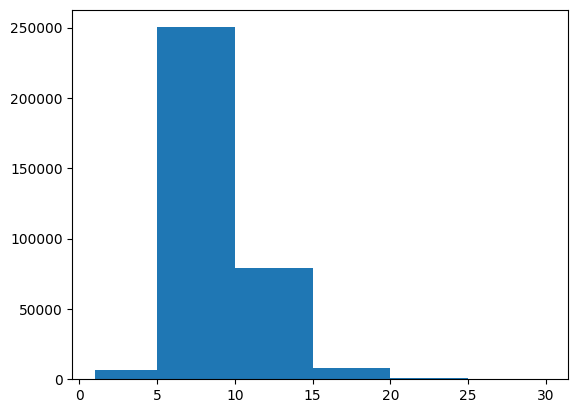

In [67]:
en_examples_length = sequencesLen(en_examples);

plt.hist(en_examples_length, [1,5,10,15,20,25,30]);

FRENCH SEQUENCES LENGTH HISTOGRAM

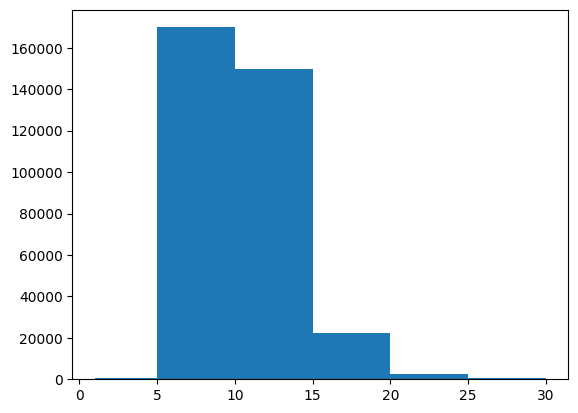

In [68]:
fr_examples_length = sequencesLen(fr_examples);

plt.hist(fr_examples_length, [1,5,10,15,20,25,30]);

Note: From these statistics, I will segment the data set into 4 parts based on the lengths of the French sequences:

1. [0,5]
2. [6,10]  
3. [11,15]
4. [15,20]

***
### *VOCAB*

In [69]:
class Vocab:
    def __init__(self, dataset2d):
        self.token_to_idx = {};
        self.idx_to_token = [];
        self.initVocab(dataset2d);
        
    def initVocab(self, dataset2d):
        token_freq = collections.Counter(
            [dataset2d[i][j] for i in range(len(dataset2d)) for j in range(len(dataset2d[i]))]);
        token_freq = token_freq.most_common();
  
        for i in range(len(token_freq)):
            self.token_to_idx[token_freq[i][0]] = i;
            self.idx_to_token.append(token_freq[i][0]);
    
    def tokenToIdx(self, dataset2d):
        for i in range(len(dataset2d)):
            for j in range(len(dataset2d[i])):
                current_token = dataset2d[i][j];

                if current_token not in self.idx_to_token:
                    dataset2d[i][j] = self.token_to_idx['<ukn>'];
                else:
                    dataset2d[i][j] = self.token_to_idx[dataset2d[i][j]];
                    
        return torch.tensor(dataset2d);
                
    def idxToToken(self, dataset2d):
        dataset2d = dataset2d.tolist();
        
        for i in range(len(dataset2d)):
            for j in range(len(dataset2d[i])):
                dataset2d[i][j] = self.idx_to_token[dataset2d[i][j]];
        return dataset2d;

    def expandVocab(self, dataset2d):
        token_freq = collections.Counter(
            [dataset2d[i][j] for i in range(len(dataset2d)) for j in range(len(dataset2d[i]))]);
        token_freq = token_freq.most_common();
  
        for i in range(len(token_freq)):
            if token_freq[i][0] not in self.idx_to_token:
                self.token_to_idx[token_freq[i][0]] = len(self.idx_to_token);
                self.idx_to_token.append(token_freq[i][0]);
    
    def __len__(self):
        return len(self.idx_to_token);

***
### *DATASETS TRAIN/TEST AND THEIR RESPECTIVE VOCABULARY*

In [70]:
def dataLoader(batch_size, shuffle, *tensors):
    TD = torch.utils.data.TensorDataset(*tensors);
    return torch.utils.data.DataLoader(TD, batch_size, shuffle);

In [71]:
## Determine the longest sequence among dataset_examples 
## and complete the other sequences with the <pad> token so that their length matches the longest.

def padding(dataset_examples):
    
    max_length = 0;

    def maxLength(dataset, max_length):
        for i in range(len(dataset)):
            if len(dataset[i]) > max_length:
                max_length = len(dataset[i]);
        return max_length;
                
    max_length = maxLength(dataset_examples, max_length);
    
    def pad(dataset, max_length):
        for i in range(len(dataset)):
            if len(dataset[i]) < max_length:
                dataset[i] += ['<pad>']*(max_length-len(dataset[i]));
        return dataset;
    
    dataset_examples = pad(dataset_examples, max_length);
                
    return dataset_examples;

In [72]:
# def datasets(source_examples, target_examples, dataset_train_size, dataset_test_size, 
#              batch_size_train, batch_size_test):
    
#     source_examples = copy.deepcopy(source_examples);
#     target_examples = copy.deepcopy(target_examples);
    
#     ## The document "en_fra.txt" provides examples in ascending order of the number of tokens.
#     ## So before delineating my training/test datasets, randomize the order of the examples,
#     ## in order to maximize the heterogeneity in both.
#     random_indexation = torch.randperm(dataset_train_size + dataset_test_size);
    
#     source_examples = source_examples[0:dataset_train_size+dataset_test_size];
#     source_examples = [source_examples[random_indexation[i]] for i in range(len(random_indexation))];
#     target_examples = target_examples[0:dataset_train_size+dataset_test_size];
#     target_examples = [target_examples[random_indexation[i]] for i in range(len(random_indexation))];

#     ## source_seq_len[i] = the number of tokens of sequence i (before padding).
#     ## The importance of these quantities lies in the calculation of the context variable C in the encoder.
#     source_seq_len = sequencesLen(source_examples);
#     source_seq_len_train = source_seq_len[0:dataset_train_size];
#     source_seq_len_test = source_seq_len[dataset_train_size:dataset_train_size+dataset_test_size];
    
#     source_examples = padding(source_examples);
#     target_examples = padding(target_examples);

#     source_vocab = Vocab(source_examples);
#     source_examples = source_vocab.tokenToIdx(source_examples);
#     target_vocab = Vocab(target_examples);
#     target_examples = target_vocab.tokenToIdx(target_examples);

#     ds_src_train = source_examples[0:dataset_train_size];
#     ds_trg_train_in = target_examples[0:dataset_train_size][:,:-1];
#     ds_trg_train_out = target_examples[0:dataset_train_size][:,1:];
#     datasets_train = dataLoader(batch_size_train, True, ds_src_train, source_seq_len_train, 
#                                 ds_trg_train_in, ds_trg_train_out); 
    
#     ds_src_test = source_examples[dataset_train_size:dataset_train_size+dataset_test_size];
#     ds_trg_test_out = target_examples[dataset_train_size:dataset_train_size+dataset_test_size][:,1:];
#     datasets_test = dataLoader(batch_size_test, False, ds_src_test, source_seq_len_test, ds_trg_test_out);
    
#     return datasets_train, datasets_test, source_vocab, target_vocab;

In [73]:
# dataset_train_size = 500;
# dataset_test_size = 10;
# batch_size_train = 500;
# batch_size_test = 10;

# datasets_train, datasets_test, source_vocab, target_vocab = datasets(en_examples, 
#                                                                      fr_examples, 
#                                                                      dataset_train_size, 
#                                                                      dataset_test_size, 
#                                                                      batch_size_train, 
#                                                                      batch_size_test);


In [74]:
# groups is a list of int, it is the list that determines the different dataset groups according to the sequences length;
# e.g. if groups = [5,10,15,20,25] then the following groups will be made:
# (0,5], (5,10], (10, 15], (15, 20], (20, 25].
#
# Assumptions: groups = [g1,g2,g3,...,gG];
# g1,g2,g3,...,gG > 0;
# g1<g2<g3<...<gG;

# The group_maker can takes the value 1 or 2 and is the parameter that determines
# from which datasets: source_examples (1) or target_examples (2) we make the groups. 

def datasets(source_examples, target_examples, groups, group_maker, batch_size_train):

    source_examples_groups, target_examples_groups = [], [];

    ## DEV # 
    ## facilitates the development of the datasets(...) function because it avoids directly modifying 
    ## the memory space of source_examples and target_examples and therefore it avoids having 
    ## to restart the whole notebook in order to reset the datasets before calling the datasets(...) function again.
    if dev_mode: 
        source_examples = copy.deepcopy(source_examples);
        target_examples = copy.deepcopy(target_examples);

    # CHECKS GROUPS ASSUMPTIONS
    if min(groups) < 0:
        raise ValueError("groups elements must be positive");
    groups.sort();

    if group_maker == 1:
        examples_len = sequencesLen(source_examples);
    else:
        examples_len = sequencesLen(target_examples);

    # CREATE GROUPS
    for i in range(len(groups)):
        group_lower_bound = 0 if i == 0 else groups[i-1];
        group_upper_bound = groups[i];

        lower_bound_true = group_lower_bound < examples_len;
        upper_bound_true = examples_len <= group_upper_bound;

        lower_upper_bound_true_indices = (lower_bound_true & upper_bound_true).nonzero(as_tuple=True)[0];

        source_examples_group = list(source_examples[i] for i in lower_upper_bound_true_indices);
        target_examples_group = list(target_examples[i] for i in lower_upper_bound_true_indices);

        source_examples_groups.append(source_examples_group);
        target_examples_groups.append(target_examples_group);

    number_groups = len(source_examples_groups);


    # SOURCE SEQUENCES LENGTH
    source_seq_len = [];
    for i in range(number_groups):
        source_seq_len.append(sequencesLen(source_examples_groups[i]));

    # PADDING 
    for i in range(number_groups):
        source_examples_groups[i] = padding(source_examples_groups[i]);
        target_examples_groups[i] = padding(target_examples_groups[i]);


    # CREATE VOCAB
    for i in range(number_groups):
        if i == 0:
            source_vocab = Vocab(source_examples_groups[i])
            target_vocab = Vocab(target_examples_groups[i]);
        else:
            source_vocab.expandVocab(source_examples_groups[i]);
            target_vocab.expandVocab(target_examples_groups[i]);

    # TOKEN TO INDEX
    for i in range(number_groups):
        source_examples_groups[i] = source_vocab.tokenToIdx(source_examples_groups[i]);
        target_examples_groups[i] = target_vocab.tokenToIdx(target_examples_groups[i]);

    
    # TRAIN DATASETS
    datasets_train = [];

    for i in range(number_groups):
        if len(source_examples_groups[i]) == 0:
            break;

        src_train = source_examples_groups[i];
        src_seq_len_train = source_seq_len[i];

        trg_train_in = target_examples_groups[i][:,:-1];
        trg_train_out = target_examples_groups[i][:,1:];

        datasets_train.append(dataLoader(batch_size_train, True, src_train, src_seq_len_train, trg_train_in, trg_train_out));

    
    return datasets_train, source_vocab, target_vocab;

In [3]:
if en_to_fr:
  if dev_mode:
      datasets_train, source_vocab, target_vocab = datasets(en_examples[0:250], fr_examples[0:250], [5,10,15,20], 1, 250);

  if prod_mode:
      datasets_train, source_vocab, target_vocab = datasets(en_examples, fr_examples, [5,10,15,20], 2, 512);

  if hyperparameters_optimization_mode:
      HO_datasets, source_vocab, target_vocab = datasets(en_examples, fr_examples, [5,10,15,20], 2, 512);
else:
  if dev_mode:
      datasets_train, source_vocab, target_vocab = datasets(fr_examples[0:250], en_examples[0:250], [5,10,15,20], 1, 250);

  if prod_mode:
      datasets_train, source_vocab, target_vocab = datasets(fr_examples, en_examples, [5,10,15,20], 2, 512);

  if hyperparameters_optimization_mode:
      HO_datasets, source_vocab, target_vocab = datasets(fr_examples, en_examples, [5,10,15,20], 2, 512);

In [76]:
len(source_vocab), len(target_vocab)

(79, 226)

Dump source_vocab and target_vocab in a pickle file in order to use them in production

In [77]:
with open("../saved_objects/vocabs.pkl", 'wb') as f:
    pickle.dump(source_vocab, f, pickle.HIGHEST_PROTOCOL);
    pickle.dump(target_vocab, f, pickle.HIGHEST_PROTOCOL);

***
### *COMPUTATIONAL DEVICE*

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

print("DEVICE : ", device);

DEVICE :  cpu


***
### *ATTENTION*

***
Note: The implementation of Multi-Head Attention below follows the implementation of the paper "Attention Is All You Need" while the schema in the notebook [MultiHeadAttention_ch11](https://github.com/Excelsior7/DIVEINTODEEPLEARNING/blob/main/Attention_mechanisms/MultiHeadAttention_ch11.md) follows the implementation of the book "Dive Into Deep Learning".

*In the first case* : 
Queries, Keys and Values are multiplied by a weight matrix WQi, WKi, WVi, respectively in the case of the ith head. (See image below for more details)

*In the second case*:
Queries, Keys and Values are multiplied by a weight matrix WQ, WK, WV, respectively. Following this transformation, Queries, Keys and Values will each be split into several parts (the same number of parts: **num_heads**), along the last dimension (dim=-1). The ith part of Queries, the ith part of Keys and the ith part of Values will form the ith head
(see [MultiHeadAttention_ch11](https://github.com/Excelsior7/DIVEINTODEEPLEARNING/blob/main/Attention_mechanisms/MultiHeadAttention_ch11.md))
***

![png](../../../plots/Transformer_fig1.png) 

"Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this." - page 5.

source : https://arxiv.org/abs/1706.03762?context=cs

In [79]:
def maskedSoftmax(QK, source_seq_len, mask):
    # QK.shape = (batch_size, num_steps, num_steps)
    
    QK_shape = QK.shape;
    
    if mask is True:
        mask_to_apply = ~(torch.arange(0,QK_shape[1])[None,:] < torch.arange(1,QK_shape[1]+1)[:,None]);
        mask_to_apply = mask_to_apply.unsqueeze(dim=0).repeat(QK_shape[0],1,1);
        
        QK[mask_to_apply] = -1e6;
    
    if source_seq_len is not None:
        steps = torch.arange(1, QK_shape[1]+1).unsqueeze(dim=0).repeat(QK_shape[1],1).unsqueeze(dim=0).repeat(QK_shape[0], 1, 1).to(device);
        valid_len = source_seq_len.unsqueeze(dim=1).unsqueeze(dim=1).repeat_interleave(repeats=QK_shape[1], dim=1);
        padding_mask = steps > valid_len;
        
        QK[padding_mask] = -1e6;
    
    return nn.functional.softmax(QK, dim=-1);

In [80]:
def scaledDotProductAttention(Q, K, V, dk, source_seq_len, mask):
    QK = torch.bmm(Q,K.transpose(1,2)) / math.sqrt(dk);
    
    return torch.bmm(maskedSoftmax(QK, source_seq_len, mask), V);

In [81]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dk, dv, dmodel):
        super().__init__();
        
        self.num_heads = num_heads;
        self.dk = dk;
        
        self.weights_params = nn.ModuleList();
        for i in range(num_heads):
            WQi = nn.Linear(dmodel,dk);
            WKi = nn.Linear(dmodel,dk);
            WVi = nn.Linear(dmodel,dv);

            weights = nn.ModuleList([WQi,WKi,WVi]);
            self.weights_params.append(weights);
            
        self.WO = nn.Linear(num_heads*dv,dmodel);
    
    def forward(self, queries, keys, values, source_seq_len=None, mask=False):
        # (queries|keys|values).shape = (batch_size, num_steps, dmodel)
        
        heads = [];
        
        for i in range(self.num_heads):
            WQi, WKi, WVi = self.weights_params[i];
            
            # ith head shape = (batch_size, num_steps, dv)
            heads.append(
                scaledDotProductAttention(WQi(queries), WKi(keys), WVi(values), self.dk, source_seq_len, mask));
        
        # heads.shape = (batch_size, num_steps, num_heads*dv)
        heads = torch.cat(heads, dim=-1);
        
        return self.WO(heads);

***
### *POSITION-WISE FEED FORWARD NETWORKS*

In [82]:
class FFN(nn.Module):
    def __init__(self, dmodel, dff):
        super().__init__();
        
        self.W1 = nn.Linear(dmodel,dff);
        self.W2 = nn.Linear(dff,dmodel);
        self.relu = nn.ReLU();
        
    def forward(self, X):
        # X.shape = (batch_size, num_steps, dmodel)
        
        return self.W2(self.relu(self.W1(X)));

***
### *RESIDUALS*

"And so what has happened was these residuals were carrying position information to every layer." - Ashish Vaswani

source : https://www.youtube.com/watch?v=5vcj8kSwBCY&t=1110s [Importance of Residuals (19:30 - 20:45)]

In [83]:
class AddandNorm(nn.Module):
    def __init__(self, dmodel, dropout=0):
        super().__init__();
        
        self.LN = nn.LayerNorm(dmodel);
        self.dropout = nn.Dropout(dropout);
    
    def forward(self, X, Y):
        # (X|Y).shape = (batch_size, num_steps, dmodel)

        return self.LN(X + self.dropout(Y));

***
### *POSITIONAL ENCODING*

![png](../../../plots/Transformer_fig2.png)

source : https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

In [84]:
class PositionalEncoding(nn.Module):
    def __init__(self, dmodel, dropout, max_seq_len=1000):
        super().__init__();
        
        # It is possible that dmodel is odd but this makes the code more complex without adding value.
        assert dmodel % 2 == 0, "dmodel must be even";
        
        self.dropout = nn.Dropout(dropout);
        
        # t.shape = (max_seq_len, dmodel/2)
        t = torch.arange(0,max_seq_len).unsqueeze(dim=1).repeat_interleave(repeats=int(dmodel/2),dim=1);
        # w.shape = (max_seq_len, dmodel/2)
        wk = 1/torch.pow(10000, torch.arange(0,dmodel,step=2)/dmodel).unsqueeze(dim=0);
        wk = wk.repeat_interleave(repeats=max_seq_len,dim=0);
        
        # pos_encoding.shape = (max_seq_len, dmodel)
        self.pos_encoding = torch.zeros(max_seq_len, dmodel);
        self.pos_encoding[:,0::2] = torch.sin(wk*t);
        self.pos_encoding[:,1::2] = torch.cos(wk*t);

        self.pos_encoding = self.pos_encoding.to(device);

    def forward(self, X):
        # X.shape = (batch_size, num_steps, dmodel)
        X_shape = X.shape;
        
        pos_encoding = self.pos_encoding[:X_shape[1],:].unsqueeze(dim=0).repeat(X.shape[0],1,1);
        
        return self.dropout(pos_encoding + X);

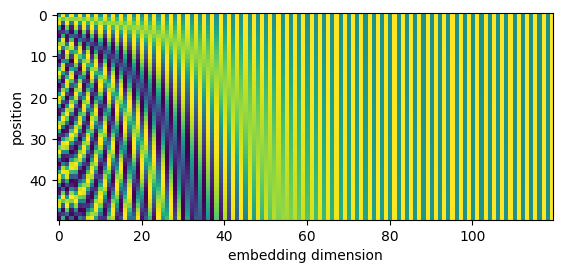

In [85]:
pe = PositionalEncoding(dmodel=120,dropout=0,max_seq_len=50).pos_encoding;
plt.imshow(pe.cpu());
plt.xlabel("embedding dimension");
plt.ylabel("position");
plt.show();

***
### *ENCODER-DECODER MODEL*

Note: 
In the "def datasets" function, I call the "def padding" function for sources_examples and target_examples independently, and what results is that "num_steps" can vary in src_X (built on sources_examples) versus bos_X (built on target_examples).

**ENCODER**

In [86]:
class EncoderBlock(nn.Module):
    def __init__(self, num_heads, dmodel, dk, dv, dff, dropout):
        super().__init__();
        
        self.MHA = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.AAN = AddandNorm(dmodel, dropout);
        self.FFN = FFN(dmodel, dff);

    def forward(self, X, source_seq_len):
        # sli_out.shape = (batch_size, number of steps in src_X, dmodel)
        # sli stands for the ith sublayer of the encoder block.
        
        sl1_out = self.MHA(X, X, X, source_seq_len);
        sl1_out = self.AAN(X, sl1_out);
        
        sl2_out = self.FFN(sl1_out)
        sl2_out = self.AAN(sl1_out, sl2_out);
        
        return sl2_out;

In [87]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout, max_seq_len=1000):
        super().__init__();
        
        self.num_blocks = num_blocks;
        self.embedding = nn.Embedding(vocab_size, dmodel);
        self.pencoding = PositionalEncoding(dmodel, dropout, max_seq_len);
        
        self.encoder_blocks = nn.ModuleList();
        for _ in range(num_blocks):
            self.encoder_blocks.append(EncoderBlock(num_heads, dmodel, dk, dv, dff, dropout));

    def forward(self, src_X, source_seq_len_train):
        
        # X.shape = (batch_size, number of steps in src_X, dmodel)
        X = self.pencoding(self.embedding(src_X));

        for i in range(self.num_blocks):
            X = self.encoder_blocks[i](X, source_seq_len_train);
            
        return X;

**DECODER**

In [88]:
class DecoderBlock(nn.Module):
    def __init__(self, num_heads, dmodel, dk, dv, dff, dropout):
        super().__init__();
        
        self.MHA1 = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.MHA2 = MultiHeadAttention(num_heads, dk, dv, dmodel);
        self.AAN = AddandNorm(dmodel, dropout);
        self.FFN = FFN(dmodel, dff);
        
    def forward(self, X, enc_output, mask=False):
        # X.shape = (batch_size, number of steps in bos_X, dmodel)
        # enc_output.shape = (batch_size, number of steps in src_X, dmodel)
        
        # sli_out.shape = (batch_size, number of steps in bos_X, dmodel)
        # sli stands for the ith sublayer of the decoder block.
        
        sl1_out = self.MHA1(X, X, X, None, mask);
        sl1_out = self.AAN(X, sl1_out);
        
        sl2_out = self.MHA2(sl1_out, enc_output, enc_output);
        sl2_out = self.AAN(sl1_out, sl2_out);
        
        sl3_out = self.FFN(sl2_out);
        sl3_out = self.AAN(sl2_out, sl3_out);
        
        return sl3_out; 

In [89]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout, max_seq_len=1000):
        super().__init__();
        
        self.num_blocks = num_blocks;
        self.embedding = nn.Embedding(vocab_size, dmodel);
        self.pencoding = PositionalEncoding(dmodel, dropout, max_seq_len);
        
        self.W_out = nn.Linear(dmodel, vocab_size);
        
        self.decoder_blocks = nn.ModuleList();
        for _ in range(num_blocks):
            self.decoder_blocks.append(DecoderBlock(num_heads, dmodel, dk, dv, dff, dropout));
        
    def forward(self, bos_X, enc_output):
        
        # X.shape = (batch_size, number of steps in bos_X, dmodel)
        X = self.pencoding(self.embedding(bos_X));
        
        mask = True if self.training else False;
        
        for i in range(self.num_blocks):
            X = self.decoder_blocks[i](X, enc_output, mask);
            
        return self.W_out(X);

**ENCODER-DECODER**

In [90]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__();
        self.encoder = encoder;
        self.decoder = decoder;
        
    def forward(self, src_X, bos_X, source_seq_len):
        # src_X.shape = (batch_size, number of steps in src_X)
        # bos_X.shape = (batch_size, number of steps in bos_X)

        enc_output = self.encoder(src_X, source_seq_len);
        Y_hat = self.decoder(bos_X, enc_output);
        
        return Y_hat;

***
### *ATTENTION IS ALL YOU NEED SCHEDULER*

In [91]:
# class AIAYNScheduler():
#     def __init__(self, optimizer, dmodel, warmup_steps):
#         self._optimizer = optimizer;
#         self._dmodel = dmodel;
#         self._warmup_steps = warmup_steps;
#         self._num_steps = 0;

#     def step(self):
#         self._num_steps += 1;
#         self._updateLR();

#     def _updateLR(self):
#         dmodel = self._dmodel;
#         ws = self._warmup_steps;
#         step = self._num_steps;

#         for g in self._optimizer.param_groups:
#             g['lr'] = (dmodel ** (-0.5)) * min(step**(-0.5), step * ws**(-1.5));

***
### *MODEL INSTANTIATION AND PARAMETERS LOADING*

In [5]:
# ENCODER PARAMETERS
source_vocab_size = len(source_vocab);

# DECODER PARAMETERS
target_vocab_size = len(target_vocab);

## Attention is all you need paper hyperparameters on base model:
# num_blocks = 6;
# num_heads = 8;
# dmodel = 512;
# dk = dv = 64;
# dff = 2048;
# dropout = 0.1;

def instantiateModel(num_blocks, num_heads, dmodel, dk, dv, dff, dropout, learning_rate, weight_decay):

    encoder = Encoder(source_vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout);
    decoder = Decoder(target_vocab_size, num_blocks, num_heads, dmodel, dk, dv, dff, dropout);
    model = EncoderDecoder(encoder, decoder);

    model.to(device);

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate);
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=30, verbose=True);

    return model, optimizer, scheduler;

In [93]:
def loadParameters(model, optimizer, load_parameters=False):
    checkpoint = torch.load('../saved_objects/parameters_Transformer_ch11.pt');
    if load_parameters:
        model.load_state_dict(checkpoint['model_state_dict']);
        optimizer.load_state_dict(checkpoint['optimizer_state_dict']);

In [94]:
if dev_mode:
  model, optimizer, scheduler = instantiateModel(2,4,128,32,32,64,0.1,0.003,0);

if prod_mode:
    model, optimizer, scheduler = instantiateModel(2,6,128,32,32,512,0.1,0.003,0.001);
    if resume_training:
      loadParameters(model, optimizer, True);

***
### *LOSS*

In [96]:
CEL = nn.CrossEntropyLoss();

In [97]:
def loss(Y_hat, Y):

    pad_idx = target_vocab.token_to_idx['<pad>'];

    Y_hat = Y_hat.reshape(-1, Y_hat.shape[-1]);
    Y = Y.flatten();
    
    is_not_pad = Y != pad_idx;
    
    Y_hat = Y_hat[is_not_pad];
    Y = Y[is_not_pad];

    return CEL(Y_hat, Y);

***
### *HYPERPARAMETERS OPTIMIZATION*

In [20]:
def hyperparametersSpace():

    HP_num_blocks = [2,4];
    HP_num_heads = [4,6];
    HP_dmodel = [128,256];
    HP_dk = HP_dv = [32,64];
    HP_dff = [512,1024];
    HP_dropout = [0.1];
    HP_learning_rate = [0.03,0.003];
    HP_weight_decay = [0.1,0.01,0.001];

    return [HP_num_blocks, HP_num_heads, HP_dmodel, HP_dk, HP_dv, HP_dff, HP_dropout, HP_learning_rate, HP_weight_decay];

In [22]:
def HO(HO_datasets, hyperparameters, loss):

  num_epochs = 2;
  max_metrics_mean, max_id = 0, None;

  for id, h in enumerate(itertools.product(*hyperparameters)):
    _num_blocks = h[0];
    _num_heads = h[1];
    _dmodel = h[2];
    _dk = h[3];
    _dv = h[4];
    _dff = h[5];
    _dropout = h[6];
    _learning_rate = h[7];
    _weight_decay = h[8];

    model, optimizer, _ = instantiateModel(_num_blocks,_num_heads,_dmodel,_dk,_dv,_dff,_dropout,_learning_rate,_weight_decay);
    metrics = [];

    model.train();
    for epoch in range(num_epochs):
        for dataset in HO_datasets:
            for src_X, source_seq_len_train, bos_X, Y in dataset:

              src_X = src_X.to(device);
              source_seq_len_train = source_seq_len_train.to(device);
              bos_X = bos_X.to(device);
              Y = Y.to(device);

              l = loss(model(src_X, bos_X, source_seq_len_train), Y);

              with torch.no_grad():
                  l.backward();
                  optimizer.step();
                  optimizer.zero_grad();

              if epoch == 1:
                metrics.append(l);
                break;

    metrics_mean = mean(metrics);
    if metrics_mean > max_metrics_mean:
      max_metrics_mean = metrics_mean;
      max_id = id;

    with open("hyperparameters_optimization.txt", "a") as f:
      f.write(f"max_id:{max_id}, num_blocks:{_num_blocks}, num_heads:{_num_heads}, dmodel:{_dmodel}, ");
      f.write(f"_dk:{_dk}, _dv:{_dv}, _dff:{_dff}, ");
      f.write(f"_dropout:{_dropout}, _learning_rate:{_learning_rate}, _weight_decay:{_weight_decay}.\n");
      f.write(f"metrics {metrics}.\n");
      f.write(f"metrics mean {metrics_mean}.\n");
      f.write("*************************************\n");
      f.close();

In [23]:
if hyperparameters_optimization_mode is True:
    hyperparameters = hyperparametersSpace();
    HO(HO_datasets, hyperparameters, loss);

0
(2, 4, 128, 32, 32, 512, 0.1, 0.03, 0.1)
1
(2, 4, 128, 32, 32, 512, 0.1, 0.03, 0.01)


***
### *TRAINING*

In [98]:
def train(num_epochs, model, datasets_train, loss, optimizer, scheduler, save_params=False):

  model.train();
  for epoch in range(num_epochs):
    for dataset in datasets_train:
        for src_X, source_seq_len_train, bos_X, Y in dataset:

            src_X = src_X.to(device);
            source_seq_len_train = source_seq_len_train.to(device);
            bos_X = bos_X.to(device);
            Y = Y.to(device);

            l = loss(model(src_X, bos_X, source_seq_len_train), Y);

            with torch.no_grad():
                l.backward();
                optimizer.step();
                optimizer.zero_grad();

        scheduler.step(l);
        print(f'Training loss {l}');

    print(f'Epoch {epoch}');
        
  if save_params:
      torch.save(model.state_dict(), '../saved_objects/parameters_Transformer_ch11.pt');

In [99]:
# train(50, model, datasets_train, loss, optimizer, scheduler, False);

***
### *PREDICTION*

In [100]:
def prediction(model,datasets,source_vocab,target_vocab):
    
    bos_idx = target_vocab.token_to_idx['<bos>'];
    eos_idx = target_vocab.token_to_idx['<eos>'];

    preds_outputs_src = [];
    preds_outputs_y = [];
    
    src_X, source_seq_len_test, Y = next(iter(datasets));    
    bos_X = torch.empty((len(src_X),1)).fill_(bos_idx).type(torch.int32);

    src_X = src_X.to(device);
    source_seq_len_test = source_seq_len_test.to(device);
    bos_X = bos_X.to(device);
    Y = Y.to(device);
    
    while(len(src_X) > 0):

        Y_hat = torch.transpose(model(src_X, bos_X, source_seq_len_test),0,1)[-1];
        preds = torch.argmax(Y_hat,dim=-1,keepdim=True);

        bos_X = torch.cat((bos_X,preds),dim=-1);

        ## Halt prediction if <eos> token.
        preds_is_eos = (preds == eos_idx).flatten();

        src_X_halt = source_vocab.idxToToken(src_X[preds_is_eos]);
        for i in range(len(src_X_halt)):
            preds_outputs_src.append(src_X_halt[i]);

        bos_X_halt = target_vocab.idxToToken(bos_X[preds_is_eos]);
        for i in range(len(bos_X_halt)):
            preds_outputs_y.append(bos_X_halt[i]);

        ## Delete terminated predictions.
        src_X = src_X[~preds_is_eos];
        bos_X = bos_X[~preds_is_eos];
        source_seq_len_test = source_seq_len_test[~preds_is_eos];
         
    return preds_outputs_src, preds_outputs_y;

In [101]:
# out_src, out_y = prediction(model, datasets_test, source_vocab, target_vocab);

# for x, y in zip(out_src, out_y):
#     print("src => ", x);
#     print("pred => ", y);
#     print("******");

In [102]:
def translateUserInput(user_input, model, source_vocab, target_vocab):

    user_input_standardized = [standardizeString(user_input, False).split(' ')];
    user_input_standardized_tokenized = source_vocab.tokenToIdx(user_input_standardized);
    # user_input_standardized_tokenized = user_input_standardized_tokenized[user_input_standardized_tokenized != unk_idx].unsqueeze(0);

    user_input_sequence_len = sequencesLen(user_input_standardized);

    # torch.tensor([[0]]) is just here to replace the Y (i.e. the traduction of the user_input) that I don't have access to in production.
    data = dataLoader(1, False, user_input_standardized_tokenized, user_input_sequence_len, torch.tensor([[0]]));

    out_src, out_y = prediction(model, data, source_vocab, target_vocab);

    for x, y in zip(out_src, out_y):
        print("src => ", x);
        print("pred => ", y);
        print("******");

In [105]:
user_input = "get away";

In [6]:
translateUserInput(user_input, model, source_vocab, target_vocab);